## testing several models for both the SeaFlow and Zinser (updated) datasets
 * modified from 2020-04-10 notebook with model using updated data fitting
 * light-dependent division appears to have much larger benefit than size-dependent growth/respiration

### load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

data_gridded[k]['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

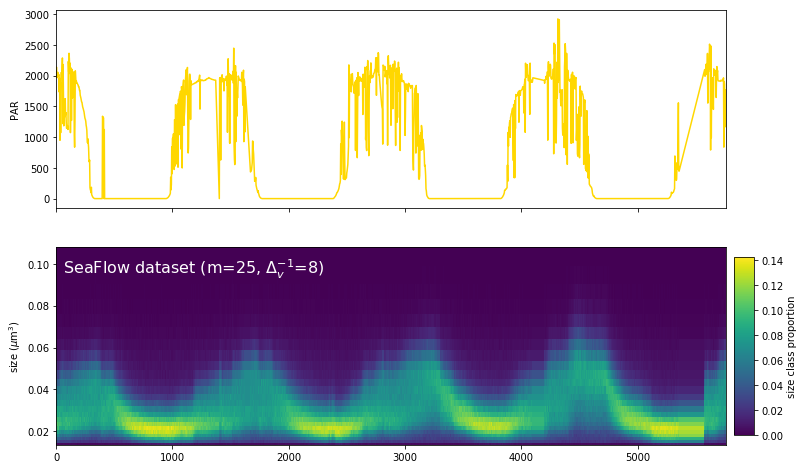

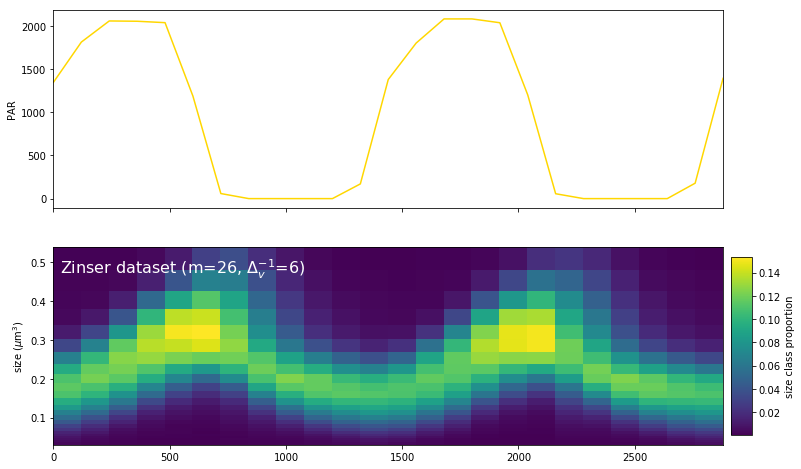

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

### process data and plot it

In [3]:
# prepare data for Stan model

data = {}
mcmcs = {}
models = {}

In [4]:
for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    if 'seaflow' in k:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[k]['time'][-1]/binsize))
        
        data[k]['obs'] = np.full((data[k]['m'],numbins), fill_value=np.nan)
        data[k]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[k]['time'] >= ibin*binsize,
                                    data_gridded[k]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[k]['obs'][:,i] = np.mean(data_gridded[k]['w_obs'][:,binind], axis=1)
                data[k]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[k]['obs'] = data[k]['obs'][:,:i]
        data[k]['t_obs'] = data[k]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[k]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[k]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[k]['obs'] = data_gridded[k]['w_obs']
        data[k]['t_obs'] = data_gridded[k]['time']
        par = data_gridded[k]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]
        
        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    data[k]['nt_obs'] = data[k]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[k]['i_test'] = np.loadtxt(itestfiles[k]).astype(int)
    # remove last index, so that dimensions agree
    data[k]['i_test'] = data[k]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[k]['obs_count'] = (1000*data[k]['obs']).astype(int)
    
    # consistency check
    if len(data[k]['i_test']) != data[k]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(k,data[k]['nt_obs'],len(data[k]['i_test'])))

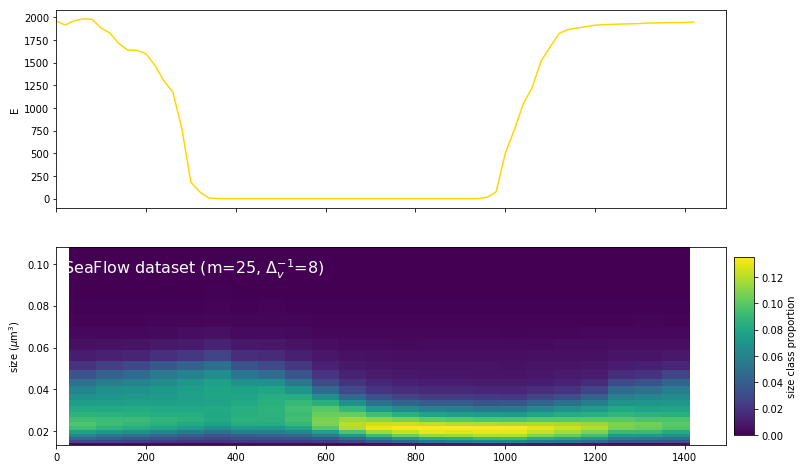

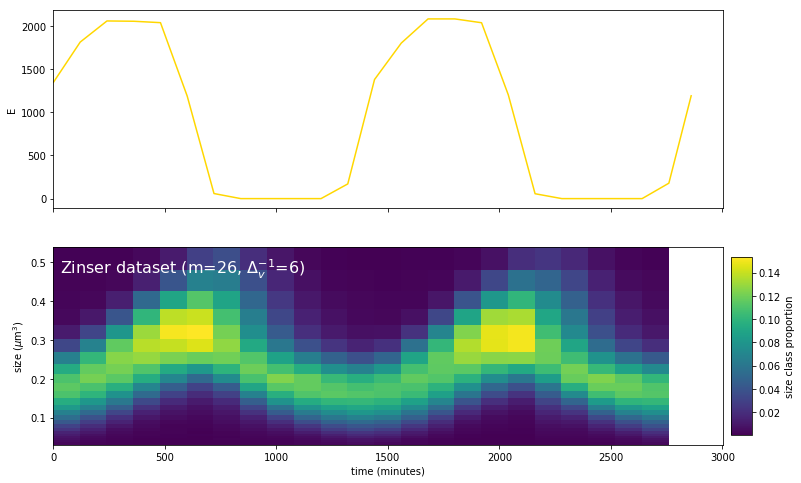

In [5]:
for i,k in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    t = np.arange(data[k]['nt'])*data[k]['dt']
    ax.plot(t, data[k]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[k]['v_min']
    delta_v = 1.0/data[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[k]['t_obs'],v,data[k]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [22]:
import pystan
refit_all = False
refit_required = {}

modelfiles = {
    #'monodeltav2_respv2_lightsig':'stancode/matrixmodel_estinilnorm_monodeltav2-lightsig_respv2_normparam_trackgrowth_xval.stan',
    #'monodeltav2_respv2_lightsig_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodeltav2-lightsig_respv2_normparam_trackgrowth_xval.stan',
    #'monodelta_respv2_lightsig':'stancode/matrixmodel_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    #'monodelta_respv2_lightsig_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_monodelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    #'freedelta_respv2_lightsig':'stancode/matrixmodel_estinilnorm_freedelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    #'freedelta_respv2_lightsig_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_freedelta-lightsig_respv2_normparam_trackgrowth_xval.stan',
    #'freedelta_respiv2':'stancode/matrixmodel_estinilnorm_freedelta_respiv2_normparam_trackgrowth_xval.stan',
    #'freedelta_respiv2_mlmn':'stancode/matrixmodel_mlmultinom_estinilnorm_freedelta_respiv2_normparam_trackgrowth_xval.stan',
    'freedelta_respv2':'stancode/matrixmodel_estinilnorm_freedelta_respv2_normparam_trackgrowth_xval.stan',
    'monodelta_respv2':'stancode/matrixmodel_estinilnorm_monodelta_respv2_normparam_trackgrowth_xval.stan',
    'monodeltav2_respv2':'stancode/matrixmodel_estinilnorm_monodeltav2_respv2_normparam_trackgrowth_xval.stan',
}
desc_model = {
    'monodelta_respv2_lightsig':'model with respiration v2, monotone deltas (exp AR1), light-dep div',
    'monodelta_respv2_lightsig_mlmn':'model with respiration v2, monotone deltas (exp AR1), light-dep div, ml multilevel',
    'monodeltav2_respv2_lightsig':'model with respiration v2, monotone deltas (sum of frac), light-dep div',
    'monodeltav2_respv2_lightsig_mlmn':'model with respiration v2, monotone deltas (sum of frac), light-dep div, ml multilevel',
    'freedelta_respv2_lightsig':'model with respiration v2, "free" deltas, light-dep div',
    'freedelta_respv2_lightsig_mlmn':'model with respiration v2, "free" deltas, light-dep div, ml multinomial',
    'freedelta_respiv2':'model with size-dep respiration v2, "free" deltas',
    'freedelta_respiv2_mlmn':'model with size-dep respiration v2, "free" deltas, ml multinomial',
    'freedelta_respv2':'model with respiration v2, "free" deltas',
    'monodelta_respv2':'model with respiration v2, monotone deltas (exp AR1)',
    'monodeltav2_respv2':'model with respiration v2, monotone deltas (sum of frac)',
}

for name in modelfiles:
    with open(modelfiles[name]) as f: 
        stan_code = f.read()
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL monodeltav2_respv2 NOW.


freedelta_respv2: unchanged code, not recompiling
monodelta_respv2: unchanged code, not recompiling
monodeltav2_respv2: code change detected, recompiling


In [23]:
# run a bunch of experiments -- this may take a while
for name in models:
    for k in data:
        if name in mcmcs:
            if k in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x))
                continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)
            # get max Rhat
            s = mcmcs[name][k].summary()
            irhat = s['summary_colnames'].index("Rhat")
            rhats = s['summary'][:,irhat]
            rhat_max = np.nanmax(rhats)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x))

freedelta_respv2 (model with respiration v2, "free" deltas)
Inference for Stan model: freedelta_respv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
delta_mu             2.76    0.02     0.6    1.7   2.34   2.72    3.14   4.08   1308    1.0
delta_sigma          1.72    0.02    0.61   0.83   1.28   1.61    2.04   3.19   1223    1.0
delta_max[1]         0.17  3.3e-3    0.14 5.8e-3   0.07   0.14    0.25   0.53   1824    1.0
delta_max[2]          0.6  8.5e-3    0.29   0.07    0.4    0.6    0.79    1.2   1199    1.0
delta_max[3]         1.12  9.8e-3    0.37   0.38   0.86   1.12    1.37   1.83   1453    1.0
delta_max[4]         1.72    0.02    0.61   0.58   1.29   1.71    2.16   2.92   1472    1.0
delta_max[5]         2.25    0.02    0.72   0.85   1.77   2.26    2.72   3.71   1794    1.0
delta_max[6]         2.81    0.02    0.84 

Inference for Stan model: monodelta_respv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
delta_lambda         1.15  8.4e-3     0.4    0.51    0.86     1.1    1.38   2.06   2287    1.0
delta_max_incr[1]    0.16  3.0e-3    0.14  7.1e-3    0.05    0.13    0.23   0.52   2112    1.0
delta_max_incr[2]    0.41  5.5e-3    0.26    0.02     0.2    0.38    0.57   0.97   2170    1.0
delta_max_incr[3]    0.48  6.5e-3    0.28    0.03    0.26    0.46    0.68   1.07   1839    1.0
delta_max_incr[4]    0.56  7.7e-3    0.36    0.03    0.28    0.51     0.8   1.32   2185    1.0
delta_max_incr[5]    0.47  6.2e-3    0.35    0.02    0.19    0.41    0.69   1.28   3135    1.0
delta_max_incr[6]    0.44  5.6e-3    0.35    0.01    0.16    0.35    0.63   1.31   3841    1.0
delta_max_incr[7]     0.4  5.7e-3    0.34    0.01    0.14    0.31    0.58   1.

monodeltav2_respv2 (model with respiration v2, monotone deltas (sum of frac))
Inference for Stan model: monodeltav2_respv2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%    25%     50%    75%   97.5%  n_eff   Rhat
delta_max_frac[1]     0.04  1.9e-4    0.01    0.02   0.03    0.04   0.05    0.07   3257    1.0
delta_max_frac[2]     0.06  2.5e-4    0.02    0.03   0.05    0.06   0.08     0.1   5170    1.0
delta_max_frac[3]     0.07  2.4e-4    0.02    0.03   0.05    0.06   0.08    0.11   5936    1.0
delta_max_frac[4]     0.06  2.4e-4    0.02    0.03   0.05    0.06   0.07     0.1   5950    1.0
delta_max_frac[5]     0.06  2.4e-4    0.02    0.03   0.05    0.06   0.07     0.1   5711    1.0
delta_max_frac[6]     0.06  2.4e-4    0.02    0.03   0.04    0.06   0.07    0.09   5008    1.0
delta_max_frac[7]     0.06  2.4e-4    0.02    0.03   0.05    0.06   0.07    0.09   5273    1.

## Plot the results

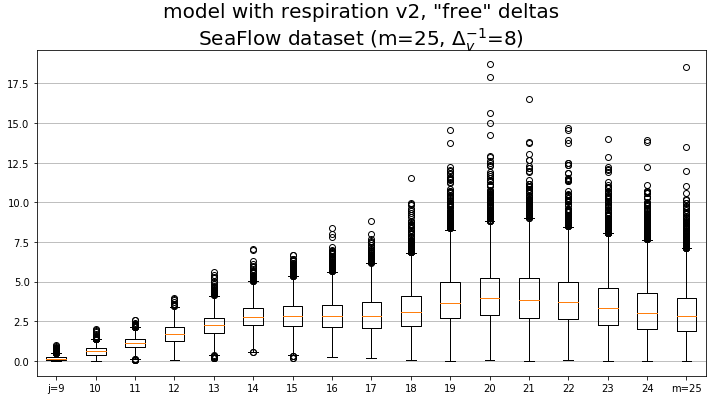

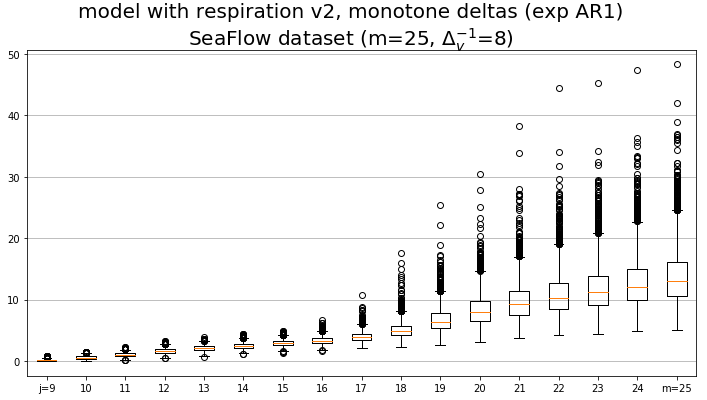

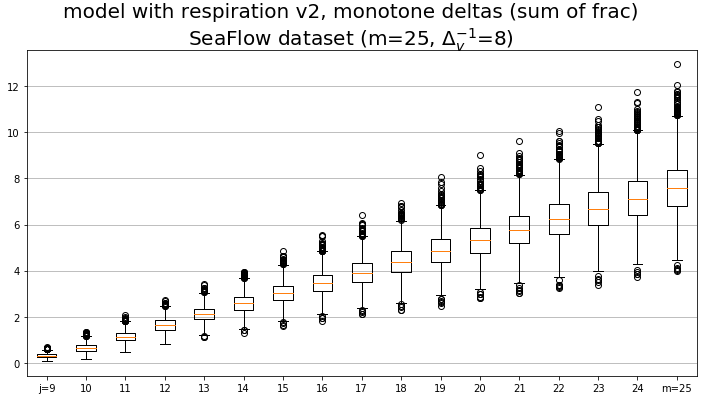

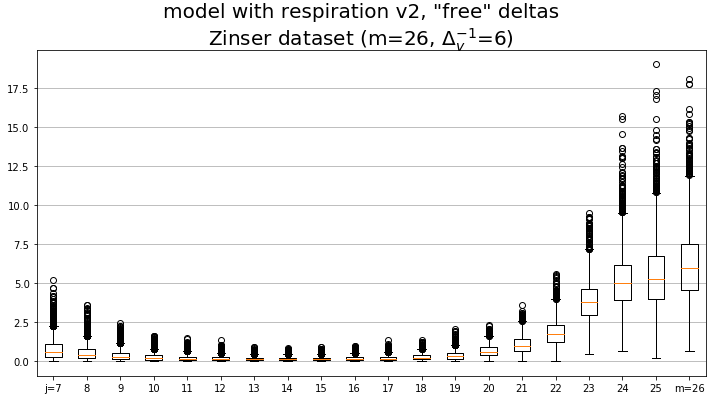

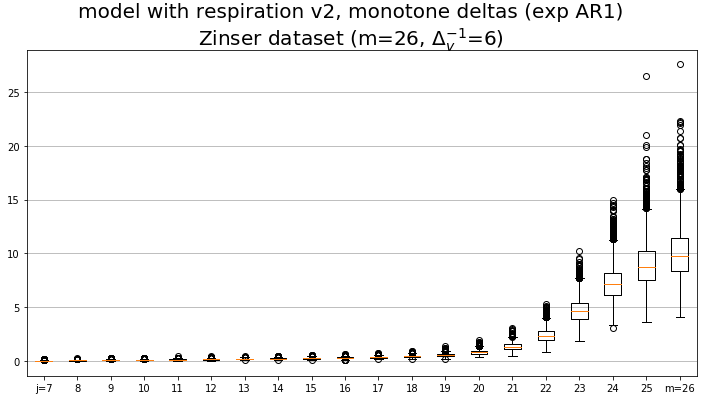

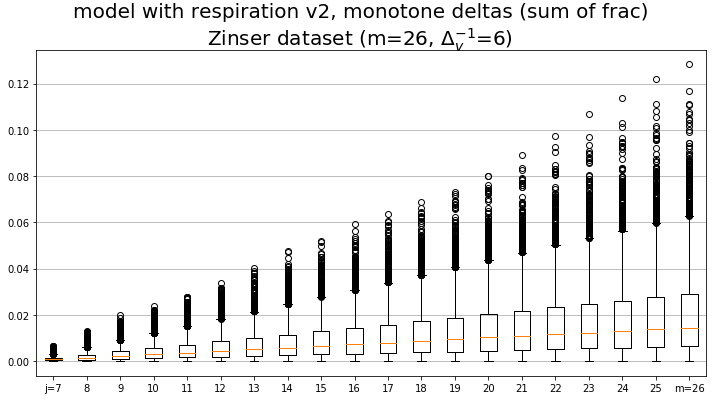

In [34]:
for k in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[k]['delta_v_inv'] + 1
        m = data_gridded[k]['m']

        fig, ax = plt.subplots(figsize=(12,6))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        ax.boxplot(mcmc[k]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        None

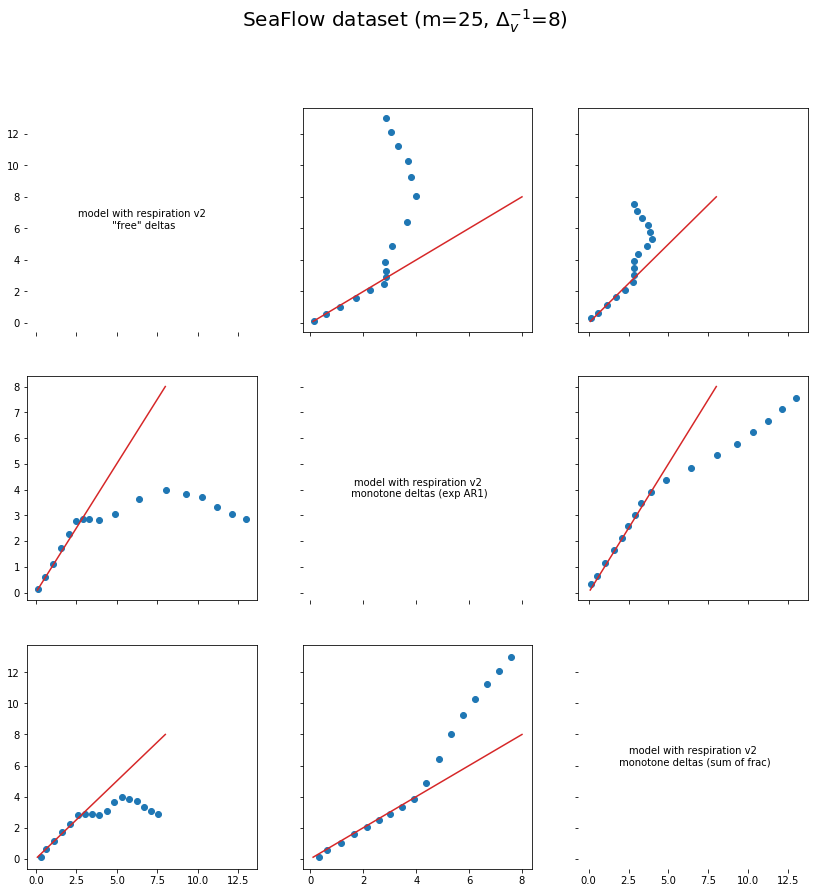

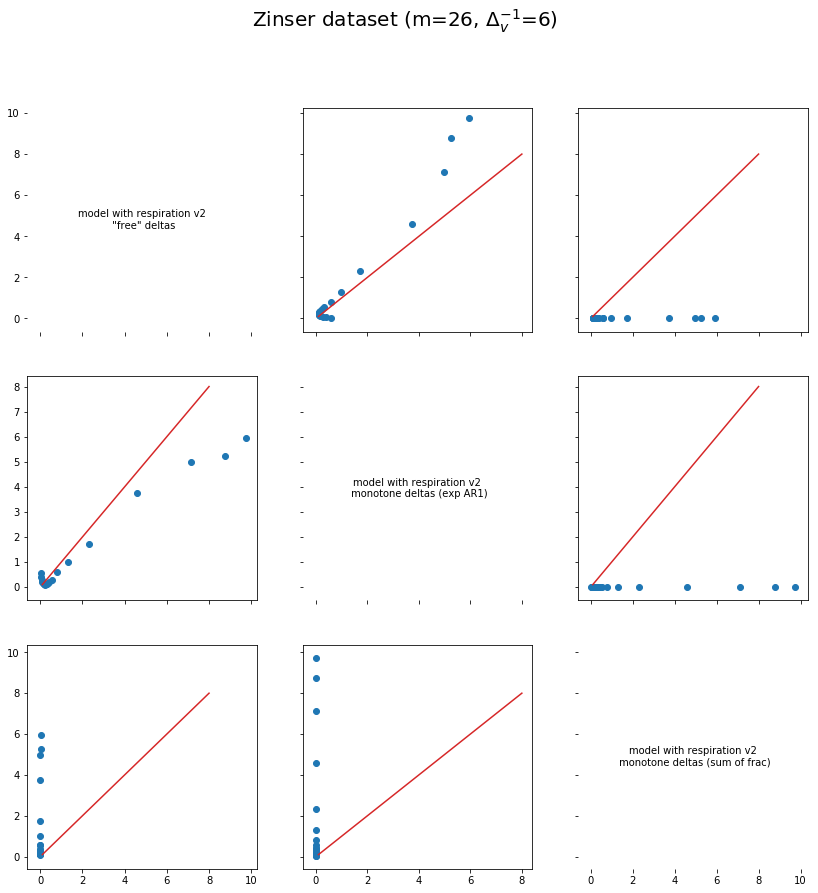

In [32]:
# create a 
for k in data:
    n = len(mcmcs)
    if n > 1:
        tmpdata = {}
        for name in mcmcs:
            tmpdata[name] = np.median(mcmcs[name][k]['delta_max'], axis=0)

        fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(14,14), sharex='col', sharey='row')
        fig.suptitle(desc[k], size=20)
        for irow,colname in enumerate(mcmcs):
            for icol,rowname in enumerate(mcmcs):
                ax = axs[irow,icol]
                if irow == icol:
                    for loc in ax.spines:
                        ax.spines[loc].set_visible(False)
                    #ax.set_visible(False)
                    #ax.set(xticks=[], yticks=[])
                    ax.text(0.5, 0.5, desc_model[colname].replace(',','\n'), transform=ax.transAxes, va='center', ha='center')
                    continue
                ax.scatter(tmpdata[colname],tmpdata[rowname])
                ax.plot([0.1, 8.0], [0.1, 8.0], color='tab:red')

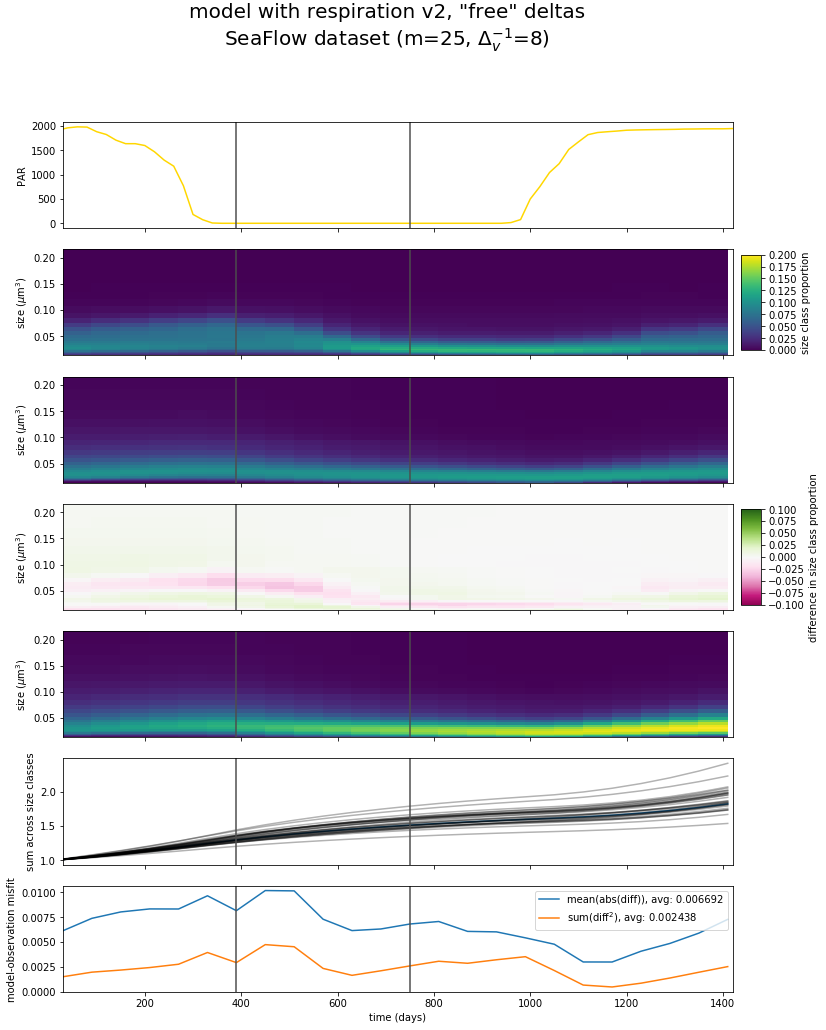

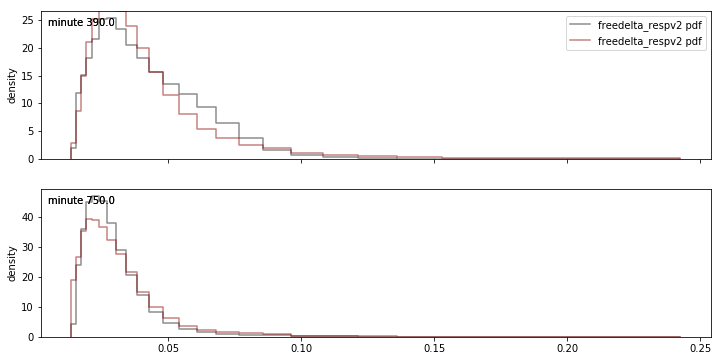

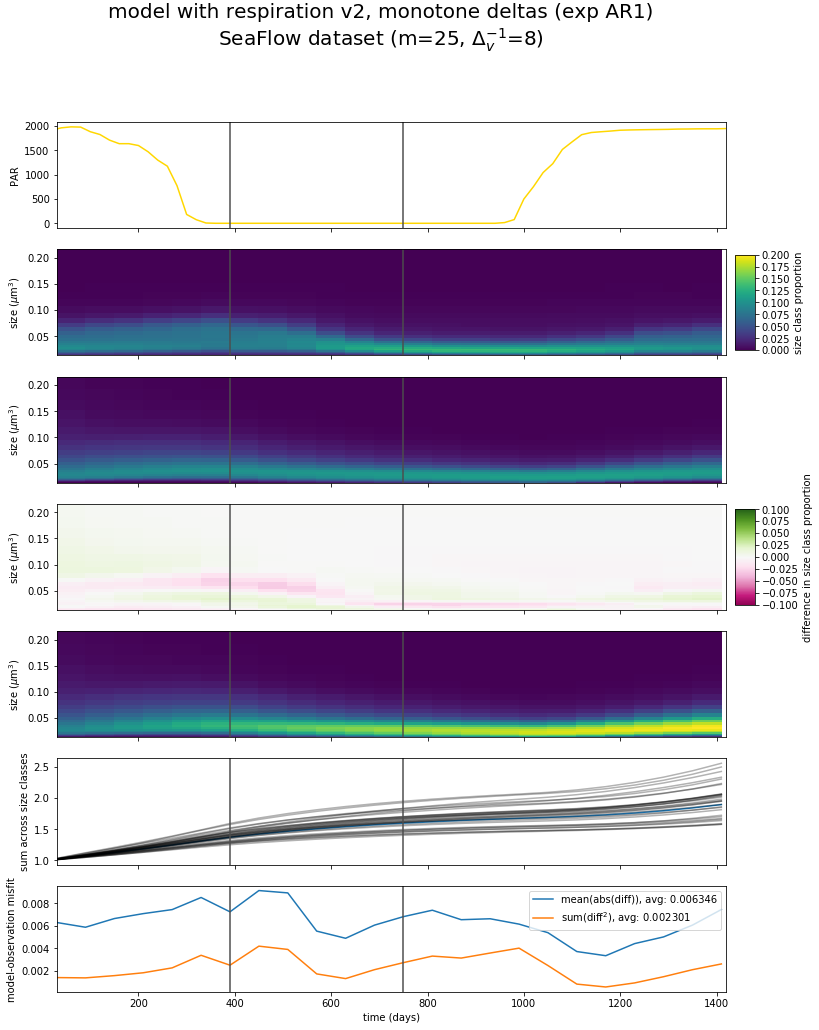

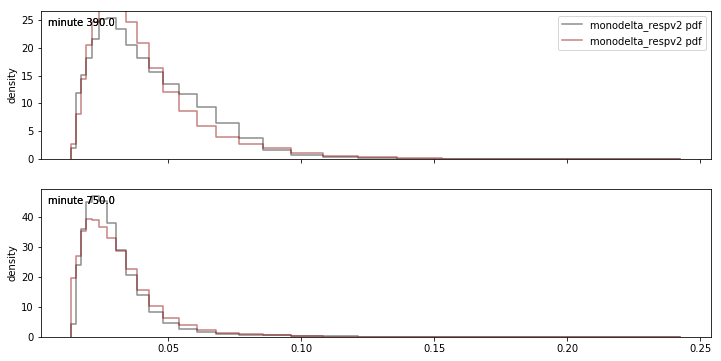

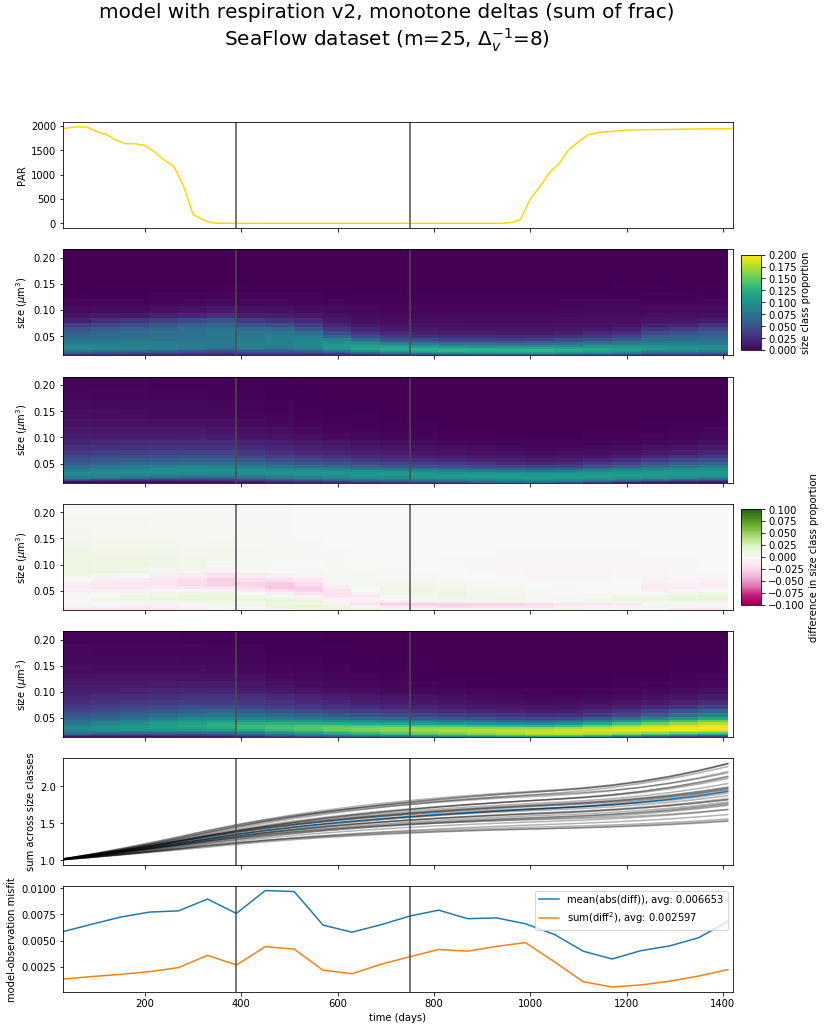

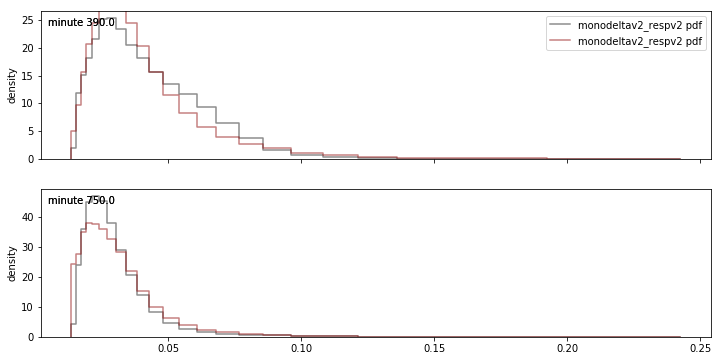

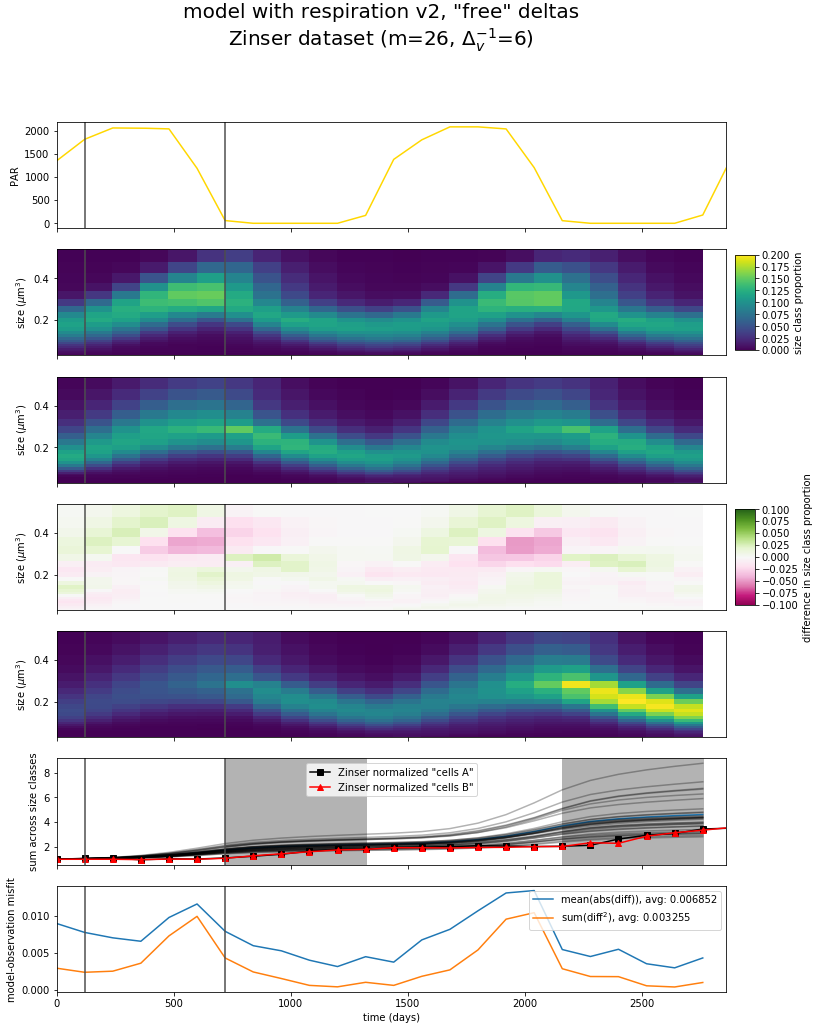

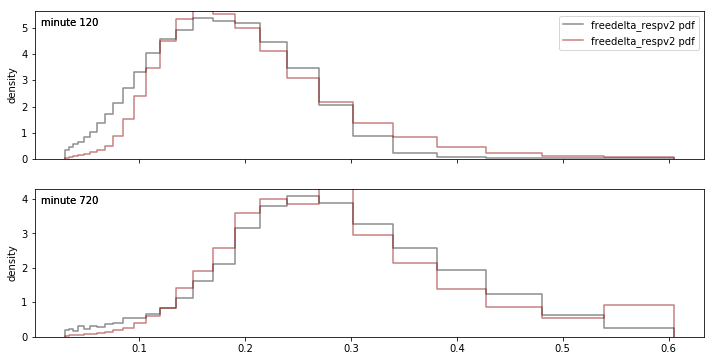

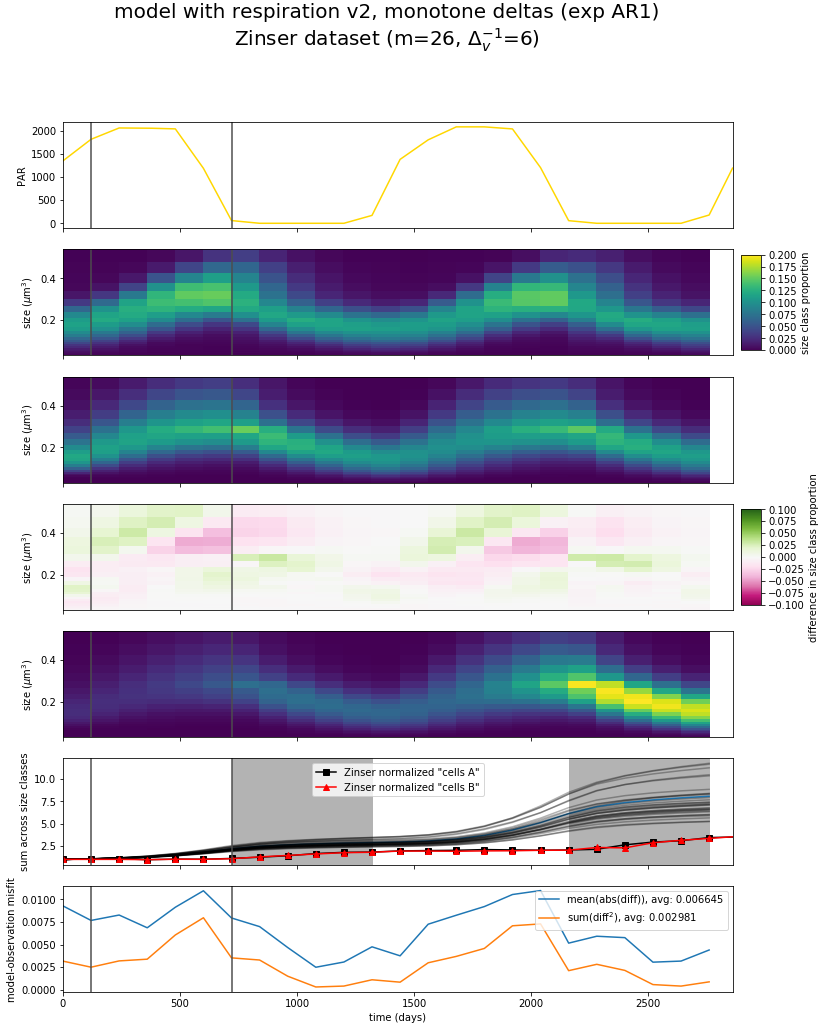

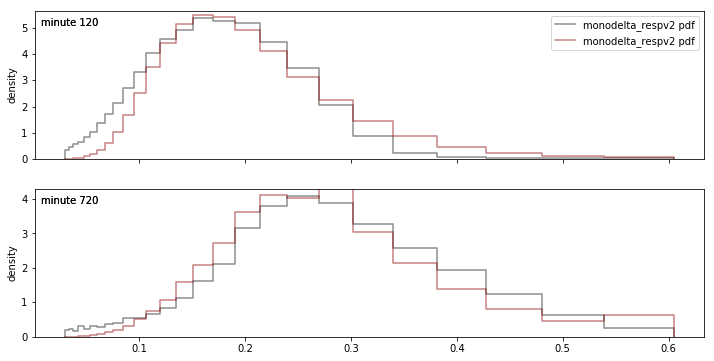

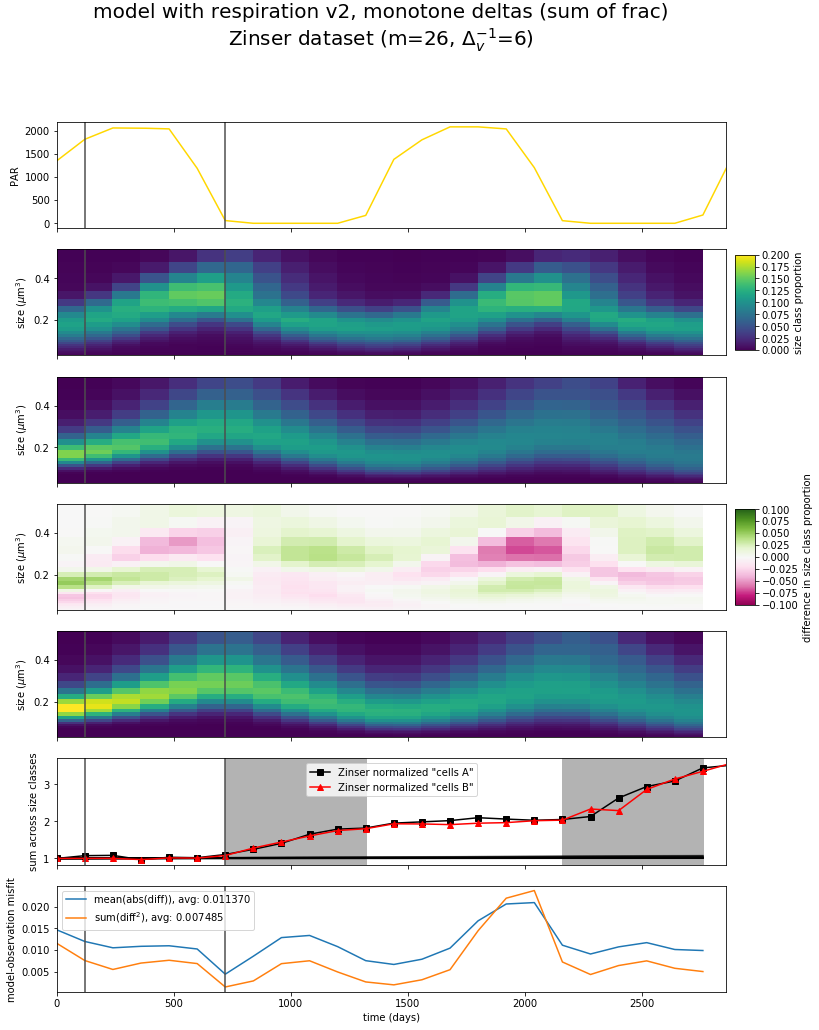

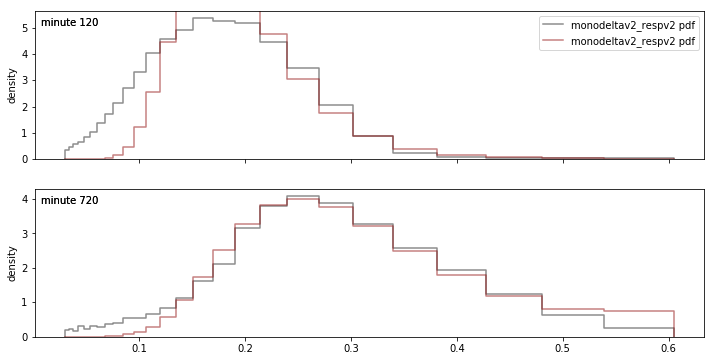

In [38]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for k in data:
    for name,mcmc in mcmcs.items():
        t = data[k]['dt']*np.arange(data[k]['nt'])
        if 'zinser' in k:
            slice_indices = [1,6]
        else:
            slice_indices = [6,12]
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

        ax = axs[4]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['model'])

        ax = axs[5]
        ax.plot(data[k]['t_obs'], np.sum(res['model'],axis=0))
        ax.plot(data[k]['t_obs'], np.sum(mcmc[k]['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
        if 'zinser' in k:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.set(ylabel='sum across size classes')

        ax = axs[6]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.legend()

        for ax in axs.flat:
            for i in slice_indices:
                ax.axvline(data[k]['t_obs'][i], color='.3')

        # plot slices

        plotdata_y = np.zeros(2*(data[k]['m']+1))

        fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
        for i,ax in zip(slice_indices,axs.flat):
            for key in ('obs','model'):
                color = colors[key]
                cdata = res[key][:,i]
                cdata /= sum(cdata)
                plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
                ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
                ax.text(0.01, 0.95, 'minute {}'.format(data[k]['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
                ax.set_ylabel('density')
                ax.set_ylim(bottom=0.0)
        axs[0].legend()
        None

In [40]:
'''
for k in data:
    for name,mcmc in mcmcs.items():
        paramnames = [v for v in mcmc[k].flatnames if not v.startswith('mod_obspos') 
                      and not v.startswith('delta_max') and not v.startswith('w_ini') and not v.startswith('theta')]
        if len(paramnames) > 12:
            print('removing some parameters from plot')
            paramnames = paramnames[:12]
        num_params = len(paramnames)

        fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        for ax in axs.flat:
            ax.set_visible(False)
        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[irow-1,icol]
                ax.set_visible(True)
                xname = paramnames[icol]
                yname = paramnames[irow]
                ax.hist2d(mcmc[k][xname],mcmc[k][yname],bins=50,cmap=mpl.cm.gray_r)
                if icol == 0:
                    ax.set_ylabel(yname)
                if irow == num_params-1:
                    ax.set_xlabel(xname)
'''
None

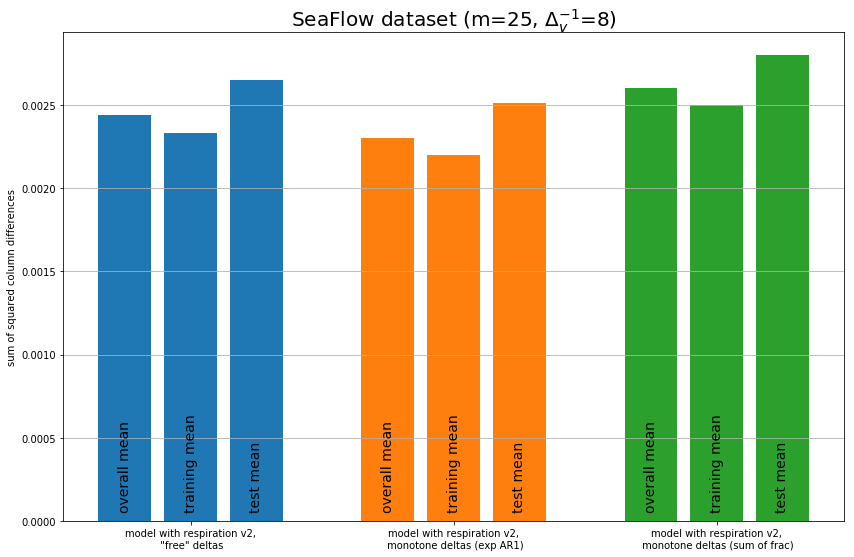

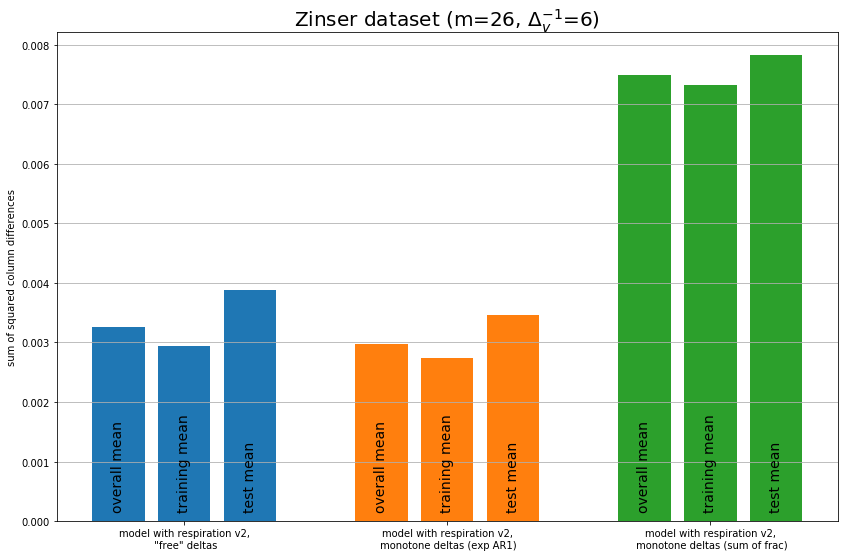

In [45]:
height = np.zeros(3)
for k in data:
    obs = data[k]['obs']
    
    fig, ax = plt.subplots(figsize=(14,9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][k]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[k]['i_test'] == 0])
        height[2] = np.mean(e[data[k]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=14)
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
        
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title(desc[k], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')